In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# maybe we can make long train_data: hsatck it with CGF==1 and CGF == 0 and make 2*n predictions vector 
def uplift_at(y_tr, cgf_tr, uplift_tr, 
              y_ts, cgf_ts, uplift_ts, at=0.5):
    
    tmp_tr = pd.DataFrame( 
        data  = np.vstack((y_tr, cgf_tr, uplift_tr)).transpose(),
        columns = ['target','cgf','uplift']  
        )
    tmp_tr.sort_values('uplift', ascending=False, inplace=True)
    tmp_tr = tmp_tr.head(int(at*tmp_tr.shape[0]))
    real_uplift_tr =  np.round(tmp_tr[tmp_tr['cgf']==0]['target'].mean() - tmp_tr[tmp_tr['cgf']==1]['target'].mean(),4) 
    if y_ts is not None:
            tmp_ts = pd.DataFrame( 
                data  = np.vstack((y_ts, cgf_ts, uplift_ts)).transpose(),
                columns = ['target','cgf','uplift']  
                )
            tmp_ts.sort_values('uplift', ascending=False, inplace=True)
            tmp_ts = tmp_ts.head(int(at*tmp_ts.shape[0]))
            real_uplift_ts =  np.round(tmp_ts[tmp_ts['cgf']==0]['target'].mean() - tmp_ts[tmp_ts['cgf']==1]['target'].mean(),4)
        
    return real_uplift_tr, real_uplift_ts

In [3]:
def offline_simulate_res(X_train, y_train, seed_split, seed_algo, parms_array):
    # 1. split 
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, 
                                               test_size=0.3,
                                               random_state=seed_split,
                                               shuffle=True,
                                               stratify=X_train['CONTROL_GROUP_FLG'])
    # 2.1 set params
    xgb_estimator = xgb.XGBClassifier( max_depth = int(parms_array[0]), 
                                       n_estimators = int(parms_array[1]),
                                       learning_rate = parms_array[2],
                                       min_child_weight = int(parms_array[3]),
                                       objective='binary:logistic',
                                       seed = seed_algo)
    # 3. Fit.
    xgb_estimator.fit(X_tr, y_tr)
    
    # 4. Get feature importance
    importance_xgb = pd.DataFrame(
        data = {
                'Feature': X_tr.columns.tolist(),
                'Importance': xgb_estimator.feature_importances_
        })
    top_imp_feat = importance_xgb.sort_values('Importance', ascending=False).head(30)

    # 5. estimate probs
    prob_tr_xgb_0 = xgb_estimator.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_tr.columns])[:,1]
    prob_tr_xgb_1 = xgb_estimator.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_tr.columns])[:,1]
    uplift_tr_xgb = prob_tr_xgb_0 - prob_tr_xgb_1

    prob_val_xgb_0 = xgb_estimator.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_val.columns])[:,1]
    prob_val_xgb_1 = xgb_estimator.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_val.columns])[:,1]
    uplift_val_xgb = prob_val_xgb_0 - prob_val_xgb_1

    # 5. Save results
    uplift_tr_xgb, uplift_ts_xgb = uplift_at(y_tr, X_tr['CONTROL_GROUP_FLG'], uplift_tr_xgb,
                                            y_val, X_val['CONTROL_GROUP_FLG'], uplift_val_xgb, 
                                            at=0.47)
    
    return  uplift_tr_xgb,  uplift_ts_xgb, top_imp_feat

In [4]:
# LOAD TRAIN: 
train = pd.read_csv('./test_data_04_2018/TRAIN_PROCESSED.csv')
identity = ['CONTRACT_REF','CLIENT_ID','SCENARIO_NAME_UNI', 'START_DATE']
train.set_index(identity, inplace=True)
train.head(3)

,,,,CONTROL_GROUP_FLG,BAL,CARD_CONTR_COUNT_0,CARD_STATUS_14,CARD_STATUS_176,CL_AMT_DOP,CL_AMT_ZP,CL_AUTO_EX,CL_EDU,FL_4P,...,CL_SOC_ST_dummy_WORKINGPENS,CL_SOC_ST_dummy_PENSIONER,CL_SOC_ST_dummy_NA,CL_SOC_ST_dummy_DECREE,CL_SOC_ST_dummy_HALFWORKER,CL_SOC_ST_dummy_CONTRACT,TOTAL_SUM_180,TOTAL_N_180,TOTAL_MAX_180,target
CONTRACT_REF,CLIENT_ID,SCENARIO_NAME_UNI,START_DATE,,,,,,,,,,,,,,,,,,,,,
273-P-99431598,105098373,UVEL_2,2017-01-23,0,0.00,3.0,1.0,2.0,3600.0,23500.0,0.0,11.0,0.0,...,1,0,0,0,0,0,0.0,0.0,0.0,1
274-P-23967129,101763714,ATM_2,2017-04-08,0,0.00,2.0,1.0,1.0,0.0,20000.0,0.0,12.0,0.0,...,0,0,0,1,0,0,0.0,0.0,0.0,1
274-P-67223249,104216626,UVEL_5,2017-01-23,0,407.44,3.0,1.0,2.0,0.0,31000.0,1.0,12.0,0.0,...,1,0,0,0,0,0,0.0,0.0,0.0,1


In [5]:
round(np.mean(train['target']),4)

0.0445

In [1]:
%%time
u_tr, u_ts, feat_imp = offline_simulate_res(X_train = train.drop(['target'], axis=1), 
                                            y_train = train['target'], 
                                            seed_split = 8373,
                                            seed_algo = 5993,
                                            parms_array = [3,100,0.1,1])
print( 'Uplift on train = ',  u_tr)
print( 'Uplift on test = ',  u_ts)

NameError: name 'offline_simulate_res' is not defined

In [73]:
%%time
u_tr, u_ts, feat_imp = offline_simulate_res(X_train = train.drop(['target'], axis=1), 
                                            y_train = train['target'], 
                                            seed_split = 30382,
                                            seed_algo = 7305,
                                            parms_array = [3,20,0.5,1])
print( 'Uplift on train = ',  u_tr)
print( 'Uplift on test = ',  u_ts)

Uplift on train =  0.0431
Uplift on test =  0.0458
Wall time: 7.18 s


In [74]:
# parms_array = [3,100,0.1,1] : 
test_1 = [ 0.0406, 0.04, 0.0408, 0.036, 0.0368,  0.0421, 0.0431]

# parms_array = [4,200,0.05,1]
test_2 = [0.0413,  0.0499,  0.0382, 0.0401, 0.0436, 0.0307, 0.0402]

# parms_array = [2,20,0.5,1]
test_3 = [0.0377,  0.0425, 0.038,  0.041,  0.035,  0.0419, 0.036, 0.0458]

In [75]:
print(round(np.mean(test_1),3))
print(round(np.mean(test_2),3))
print(round(np.mean(test_3),3))

0.04
0.041
0.04


In [77]:
good_feat.append(feat_imp)

In [130]:
#feat_imp

In [105]:
good_feat_list = [ feat_tab['Feature'].values.tolist() for  feat_tab in good_feat]
good_feat_list = [ x for feat_list in good_feat_list for x in feat_list]

In [106]:
good_feat_list = [ x for feat_list in good_feat_list for x in feat_list]

In [125]:
%%time
u_tr, u_ts, feat_imp = offline_simulate_res(X_train = train[[ x for x in set(good_feat_list)]],
                                            y_train = train['target'], 
                                            seed_split = 173482,
                                            seed_algo = 14121432,
                                            parms_array = [3,100,0.1,1])
print( 'Uplift on train = ',  u_tr)
print( 'Uplift on test = ',  u_ts)

Uplift on train =  0.0452
Uplift on test =  0.0394
Wall time: 13.6 s


In [126]:
# parms_array = [3,100,0.1,1]
test_4 = [0.0438, 0.0322,  0.0357, 0.0434, 0.0446, 0.0417,  0.0409, 0.0394]

In [127]:
print(round(np.mean(test_4),3))

0.04


In [129]:
# SAVE top inport features
print(len(set(good_feat_list)))
with open("./test_data_04_2018/top_feat_list.bin", "wb") as fp:
    pickle.dump(set(good_feat_list), fp)

47


In [7]:
# LOAD TEST: 
test = pd.read_csv('./test_data_04_2018/TEST_PROCESSED.csv')
identity_test = ['CONTRACT_REF','CLIENT_ID', 'START_DATE']
test.set_index(identity_test, inplace=True)
test.head(3)

,,,CONTROL_GROUP_FLG,BAL,CARD_CONTR_COUNT_0,CARD_STATUS_14,CARD_STATUS_176,CL_AMT_DOP,CL_AMT_ZP,CL_AUTO_EX,CL_EDU,FL_4P,...,CL_SOC_ST_dummy_NOTWORKER,CL_SOC_ST_dummy_WORKINGPENS,CL_SOC_ST_dummy_PENSIONER,CL_SOC_ST_dummy_NA,CL_SOC_ST_dummy_DECREE,CL_SOC_ST_dummy_HALFWORKER,CL_SOC_ST_dummy_CONTRACT,TOTAL_SUM_180,TOTAL_N_180,TOTAL_MAX_180
CONTRACT_REF,CLIENT_ID,START_DATE,,,,,,,,,,,,,,,,,,,,,
273-P-90421929,103016707,NaN,0,0.00,1,1.0,0.0,12000.0,20000.000000,0.000000,16.000000,0.000000,...,0,0,0,0,0,0,0,0.0,0.0,0.0
271-P-21418527,104531162,NaN,0,0.00,1,1.0,0.0,0.0,11000.000000,0.000000,11.000000,0.000000,...,0,0,0,0,0,0,0,0.0,0.0,0.0
271-P-52238588,111239640,NaN,0,344.46,1,1.0,0.0,0.0,20716.503029,0.308656,13.787112,0.029114,...,0,0,0,1,0,0,0,0.0,0.0,0.0


In [137]:
train.head()

,,,,CONTROL_GROUP_FLG,BAL,CARD_CONTR_COUNT_0,CARD_STATUS_14,CARD_STATUS_176,CL_AMT_DOP,CL_AMT_ZP,CL_AUTO_EX,CL_EDU,FL_4P,...,CL_SOC_ST_dummy_WORKINGPENS,CL_SOC_ST_dummy_PENSIONER,CL_SOC_ST_dummy_NA,CL_SOC_ST_dummy_DECREE,CL_SOC_ST_dummy_HALFWORKER,CL_SOC_ST_dummy_CONTRACT,TOTAL_SUM_180,TOTAL_N_180,TOTAL_MAX_180,target
CONTRACT_REF,CLIENT_ID,SCENARIO_NAME_UNI,START_DATE,,,,,,,,,,,,,,,,,,,,,
273-P-99431598,105098373,UVEL_2,2017-01-23,0,0.00,3.0,1.0,2.0,3600.0,23500.0,0.0,11.0,0.0,...,1,0,0,0,0,0,0.0,0.0,0.0,1
274-P-23967129,101763714,ATM_2,2017-04-08,0,0.00,2.0,1.0,1.0,0.0,20000.0,0.0,12.0,0.0,...,0,0,0,1,0,0,0.0,0.0,0.0,1
274-P-67223249,104216626,UVEL_5,2017-01-23,0,407.44,3.0,1.0,2.0,0.0,31000.0,1.0,12.0,0.0,...,1,0,0,0,0,0,0.0,0.0,0.0,1
273-P-51055302,102113400,Sc_6,2016-12-15,0,45.05,1.0,1.0,0.0,30000.0,50000.0,0.0,16.0,0.0,...,0,0,0,0,0,0,0.0,0.0,0.0,1
271-P-09670370,101989621,UVEL_1,2017-01-19,0,-27803.59,1.0,1.0,0.0,2000.0,10000.0,1.0,16.0,0.0,...,1,0,0,0,0,0,15500.0,6.0,3000.0,1


In [8]:
#test.columns.tolist() == [x for x in train.columns.tolist() if x != 'target']
sum([ (test.columns.tolist()[i] == [x for x in train.columns.tolist() 
                                    if x != 'target'][i])*1.0 for i in range(test.shape[1])]) == 119

True

In [49]:
train = shuffle(train, random_state=41)

In [50]:
%%time
# MODEL 
xgb_estimator = xgb.XGBClassifier( max_depth = 3, 
                                   n_estimators = 100,
                                   learning_rate = 0.1,
                                   min_child_weight = 1,
                                   objective='binary:logistic',
                                   seed = 42)

xgb_estimator.fit(X=train.drop(['target'], axis=1), 
                  y=train['target'])

Wall time: 36.5 s


In [51]:
importance_xgb = pd.DataFrame(
        data = {
                'Feature': train.drop(['target'], axis=1).columns.tolist(),
                'Importance': xgb_estimator.feature_importances_
        })
top_imp_feat = importance_xgb.sort_values('Importance', ascending=False).head(20)
print(top_imp_feat)

                        Feature  Importance
56       LAST_CONTR_STATUS_DT_N    0.160637
39   TOTAL_BAL_POS_CHNG_MAX_180    0.094067
55        LAST_CARD_STATUS_DT_N    0.086831
0             CONTROL_GROUP_FLG    0.065123
2            CARD_CONTR_COUNT_0    0.063676
1                           BAL    0.041968
6                     CL_AMT_ZP    0.036179
116               TOTAL_SUM_180    0.030391
28                   LIM_RECENT    0.030391
24         LIM_AVG_N_POS_CHANGE    0.030391
57                          AGE    0.028944
49   TOTAL_BAL_POS_CHNG_SUM_180    0.021708
33               REP_POPULATION    0.020260
22               LIM_AVG_CHANGE    0.020260
5                    CL_AMT_DOP    0.015919
20                         Home    0.015919
42   TOTAL_BAL_POS_CHNG_MIN_180    0.015919
117                 TOTAL_N_180    0.013025
12                      FL_GOLD    0.013025
15                      FL_PENS    0.013025


In [52]:
prob_tr_xgb_0 = xgb_estimator.predict_proba(train.drop([ 'target','CONTROL_GROUP_FLG'], axis=1).\
                                            assign(CONTROL_GROUP_FLG = 0)[train.drop(['target'], axis=1).columns])[:,1]
prob_tr_xgb_1 = xgb_estimator.predict_proba(train.drop([ 'target','CONTROL_GROUP_FLG'], axis=1).\
                                            assign(CONTROL_GROUP_FLG = 1)[train.drop(['target'], axis=1).columns])[:,1]
uplift_tr_xgb = prob_tr_xgb_0 - prob_tr_xgb_1


prob_ts_xgb_0 = xgb_estimator.predict_proba(test.drop('CONTROL_GROUP_FLG', axis=1).\
                                            assign(CONTROL_GROUP_FLG = 0)[test.columns])[:,1]
prob_ts_xgb_1 = xgb_estimator.predict_proba(test.drop('CONTROL_GROUP_FLG', axis=1).\
                                            assign(CONTROL_GROUP_FLG = 1)[test.columns])[:,1]
uplift_ts_xgb = prob_ts_xgb_0 - prob_ts_xgb_1

In [53]:
u_tr, a = uplift_at(train['target'].values, train['CONTROL_GROUP_FLG'], uplift_tr_xgb,
                    train['target'].values, train['CONTROL_GROUP_FLG'], uplift_tr_xgb, at=0.47)
print(u_tr)
print(a)

0.0417
0.0417


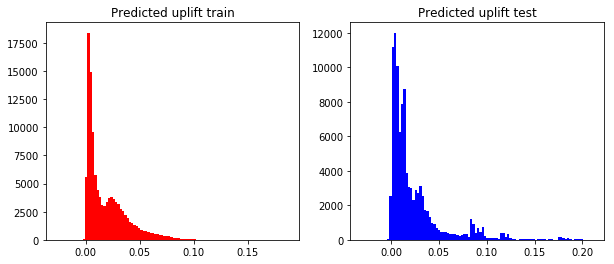

In [274]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(uplift_tr_xgb, bins=100, color='red')
axes[0].title.set_text('Predicted uplift train')
axes[1].hist(uplift_ts_xgb, bins=100, color='blue')
axes[1].title.set_text('Predicted uplift test');

In [55]:
test.shape

(102516, 119)

In [59]:
test.head()

,,,CONTROL_GROUP_FLG,BAL,CARD_CONTR_COUNT_0,CARD_STATUS_14,CARD_STATUS_176,CL_AMT_DOP,CL_AMT_ZP,CL_AUTO_EX,CL_EDU,FL_4P,...,CL_SOC_ST_dummy_NOTWORKER,CL_SOC_ST_dummy_WORKINGPENS,CL_SOC_ST_dummy_PENSIONER,CL_SOC_ST_dummy_NA,CL_SOC_ST_dummy_DECREE,CL_SOC_ST_dummy_HALFWORKER,CL_SOC_ST_dummy_CONTRACT,TOTAL_SUM_180,TOTAL_N_180,TOTAL_MAX_180
CONTRACT_REF,CLIENT_ID,START_DATE,,,,,,,,,,,,,,,,,,,,,
273-P-90421929,103016707,NaN,0,0.00,1,1.0,0.0,12000.0,20000.000000,0.000000,16.000000,0.000000,...,0,0,0,0,0,0,0,0.0,0.0,0.0
271-P-21418527,104531162,NaN,0,0.00,1,1.0,0.0,0.0,11000.000000,0.000000,11.000000,0.000000,...,0,0,0,0,0,0,0,0.0,0.0,0.0
271-P-52238588,111239640,NaN,0,344.46,1,1.0,0.0,0.0,20716.503029,0.308656,13.787112,0.029114,...,0,0,0,1,0,0,0,0.0,0.0,0.0
271-P-77201540,113595867,NaN,0,0.00,1,1.0,0.0,0.0,20716.503029,0.308656,13.787112,0.029114,...,0,0,0,1,0,0,0,0.0,0.0,0.0
271-P-53435308,104788677,NaN,0,0.00,1,1.0,0.0,0.0,10000.000000,0.308656,12.000000,0.000000,...,0,0,0,0,0,1,0,0.0,0.0,0.0


In [302]:
id_file = pd.read_csv('./test_data_04_2018/MICR_FINAL_IDS.csv', delimiter=';')
id_file.columns = ['CONTRACT_REF', 'CLIENT_ID']

In [303]:
id_file.head()

,CONTRACT_REF,CLIENT_ID
0,271-P-73914560,109934951
1,271-P-85570790,113274705
2,271-P-28494910,112304817
3,271-P-62910309,102105734
4,271-P-76072195,110000293


In [304]:
out_data = test.reset_index()[['CONTRACT_REF', 'CLIENT_ID', 'CL_AMT_ZP']]
out_data = out_data.assign( Prob_comm = prob_ts_xgb_0,
                            Prob_not_comm =  prob_ts_xgb_1, 
                            Uplift = uplift_ts_xgb)
out_data.sort_values('Uplift', ascending=False, inplace=True)

In [306]:
out_data = out_data.merge(id_file, how='inner', on = ['CONTRACT_REF', 'CLIENT_ID'])

In [308]:
print(out_data.shape)

(92220, 6)


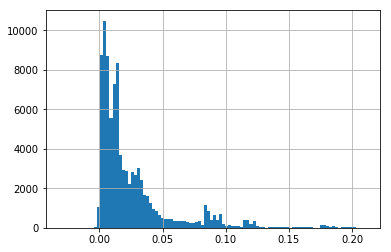

In [309]:
out_data['Uplift'].hist(bins=100);

In [314]:
N_sent = 48000
out_data = out_data.assign(top_ind = np.hstack((np.ones(N_sent), np.zeros(out_data.shape[0]-N_sent))))
print(out_data['top_ind'].mean())
print(out_data[out_data['top_ind']==1]['Uplift'].min())
print(out_data[out_data['top_ind']==0]['Uplift'].max())

0.5204944697462589
0.013163655
0.013163655


In [315]:
# shuffle data 
out_data = shuffle(out_data, random_state=17)

In [316]:
N_group = 6000
SCEN = pd.Series( ['UVEL_1']*N_group + ['UVEL_3']*N_group  + ['UVEL_4']*N_group + ['POS_2']*N_group + \
               ['ATM_1']*N_group + ['ATM_3']*N_group + ['CG']*N_group*2) 
                 #+ ['not_sent']*(test.shape[0]-N_sent))
SCEN = shuffle(SCEN, random_state=67)
print( len(SCEN) == N_sent)

True


In [317]:
SCEN.value_counts()
#SCEN[0:100]

CG        12000
POS_2      6000
ATM_3      6000
ATM_1      6000
UVEL_3     6000
UVEL_4     6000
UVEL_1     6000
dtype: int64

In [318]:
out_data.head()

,CONTRACT_REF,CLIENT_ID,CL_AMT_ZP,Prob_comm,Prob_not_comm,Uplift,top_ind
1414,271-P-54270440,114699842,20716.503029,0.334835,0.210210,0.124624,1.0
28681,271-P-25065761,102636477,10000.000000,0.080825,0.054525,0.026300,1.0
66266,271-P-58931715,104534535,13000.000000,0.012600,0.005782,0.006817,0.0
58661,273-P-01867210,102145675,80000.000000,0.018604,0.008676,0.009928,0.0
75861,271-P-12313448,104953788,25000.000000,0.011549,0.006674,0.004875,0.0


In [319]:
out_data = out_data.assign(SCEN = ['not_sent']*out_data.shape[0])
out_data['SCEN'][out_data['top_ind']==1] = SCEN.values
#out_data['SCEN'][out_data['top_ind']==0] = 'not_sent'

C:\Users\Liksakov\AppData\Local\Continuum\anaconda3_2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [320]:
out_data['SCEN'].value_counts()

not_sent    44220
CG          12000
POS_2        6000
ATM_3        6000
ATM_1        6000
UVEL_3       6000
UVEL_4       6000
UVEL_1       6000
Name: SCEN, dtype: int64

In [321]:
out_data['SCEN'][out_data['top_ind'] == 1].value_counts()

CG        12000
POS_2      6000
ATM_3      6000
ATM_1      6000
UVEL_3     6000
UVEL_4     6000
UVEL_1     6000
Name: SCEN, dtype: int64

In [322]:
out_data = out_data.assign( CGF =  pd.Series([out_data['SCEN'].values == 'CG'])[0])
out_data['CGF'][out_data['SCEN'] == 'not_sent'] = 'not_sent'
out_data['CGF'] = out_data['CGF'].map({'not_sent':-1,
                                        True:1,
                                        False:0})

C:\Users\Liksakov\AppData\Local\Continuum\anaconda3_2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [292]:
#out_data.tail(30)

In [323]:
# Checks:
out_data.groupby(['SCEN'])['Uplift'].mean().sort_values(ascending=False)

SCEN
ATM_3       0.043351
UVEL_1      0.043234
POS_2       0.043086
UVEL_4      0.043020
CG          0.042926
UVEL_3      0.042325
ATM_1       0.041924
not_sent    0.006495
Name: Uplift, dtype: float32

In [327]:
#out_data.tail(30)

In [328]:
out_data.to_csv('./test_data_04_2018/MICR_BASE_FINAL_04_2018.csv', index=False)

In [ ]:
def offline_simulation()

In [332]:
import plotly

ModuleNotFoundError: No module named 'plotly'

In [331]:
!pip install plotly

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectTimeoutError(<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x0000008EDF30E898>, 'Connection to pypi.python.org timed out. (connect timeout=15)')': /simple/plotly/
  Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectTimeoutError(<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x0000008EDF30E630>, 'Connection to pypi.python.org timed out. (connect timeout=15)')': /simple/plotly/
  Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectTimeoutError(<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x0000008EDF30E668>, 'Connection to pypi.python.org timed out. (connect timeout=15)')': /simple/plotly/
  Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broke